In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## Section 1: Apply Rejections

Remove participants with less than 50% accuracy in the go to win (GW) condition.

In [2]:
## Load data.
data = read_csv(os.path.join('data','v0.2','data.csv'))

## Define block order.
f = lambda x: 1 if np.sum(x[:4]=='GW')==2 else 2 
data['version'] = data.groupby('subject').robot.transform(f)

## Re-format columns.
data['outcome'] = data.outcome.replace({10:1, 1:0, -1:1, -10:0})

## Compute accuracy within subjects.
gb = data.groupby('subject').accuracy.mean()
print('Fraction of suspect participants: %0.2f' %(gb < 0.55).mean())

## Identify and remove suspect participants.
reject = gb[gb > 0.55].index
data = data[data.subject.isin(reject)]

Fraction of suspect participants: 0.20


## Section 2: Overall Performance

#### 2.1 Learning Curves

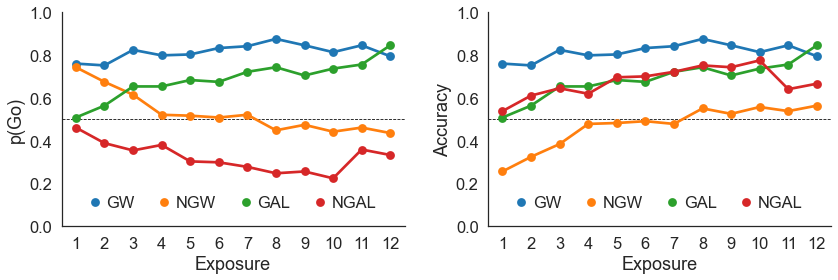

In [3]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4))

## Iterate over variables.
for ax, var in zip(axes,['choice','accuracy']):
    
    ## Plot performance.
    sns.pointplot(x='exposure', y=var, hue='robot', data=data, 
                  hue_order=['GW','NGW','GAL','NGAL'], ci=None, ax=ax)

    ## Add detail.
    ylabel = 'p(Go)' if var == 'choice' else var.capitalize()
    ax.axhline(0.5, lw=0.8, linestyle='--', color='k', zorder=-1)
    ax.set(xlabel='Exposure', ylim=(0,1), ylabel=ylabel)
    ax.legend(loc=3,ncol=4,frameon=False,borderpad=0.5,handletextpad=-0.3,columnspacing=0.8)

sns.despine()
plt.tight_layout()

#### 2.2 Individual Differences

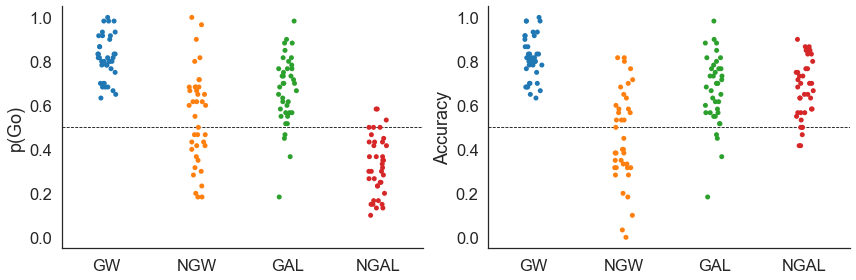

In [4]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4))

## Iterate over variables.
for ax, var in zip(axes,['choice','accuracy']):

    ## Compute average within subjects.
    gb = data.groupby(['subject','robot'])[var].mean().reset_index()

    ## Plot performance.
    sns.stripplot(x='robot', y=var, data=gb, order=['GW','NGW','GAL','NGAL'], ax=ax)
    
    ## Add detail.
    ylabel = 'p(Go)' if var == 'choice' else var.capitalize()
    ax.axhline(0.5, lw=0.8, linestyle='--', color='k', zorder=-1)
    ax.set(xlabel='', ylim=(-0.05,1.05), ylabel=ylabel)
    
sns.despine()
plt.tight_layout()

## Section 3: Block Effects

#### 3.1 Learning Curves

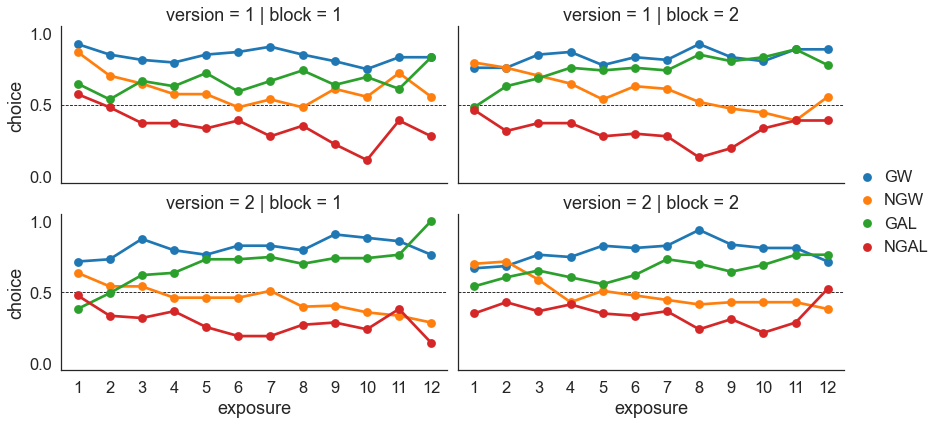

In [5]:
## Initialize canvas.
g = sns.FacetGrid(data, row='version', col='block', row_order=[1,2], col_order=[1,2], aspect=2)
palette = sns.color_palette(n_colors=4)

## Plot performance.
g.map(sns.pointplot, 'exposure', 'choice', 'robot', order=np.arange(12)+1,
      hue_order=['GW','NGW','GAL','NGAL'], palette=palette, ci=None)

## Add details.
g.set(ylim=(-0.05,1.05))
g.add_legend(handletextpad=0)
for ax in g.axes.flatten(): ax.axhline(0.5, lw=0.8, linestyle='--', color='k', zorder=-1)

#### 3.2 Individual Differences

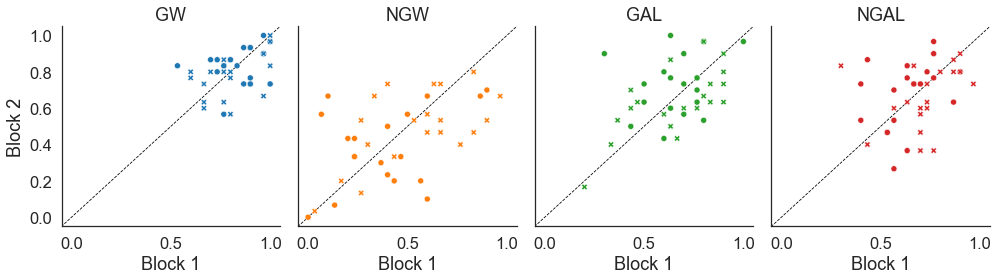

In [6]:
## Initialize canvas.
fig, axes = plt.subplots(1,4,figsize=(14,4),sharex=True,sharey=True)
palette = sns.color_palette(n_colors=4).as_hex()

## Compute average within subjects.
gb = data.groupby(['version','subject','block','robot']).accuracy.mean().reset_index()
gb = gb.pivot_table('accuracy',['subject','version'],['robot','block'])

## Iterate over conditions.
for ax, robot, color in zip(axes, ['GW','NGW','GAL','NGAL'], palette):
    
    ## Plot performance.
    sns.scatterplot(x='x', y='y', data=gb[robot].rename(columns={1:'x', 2:'y'}), 
                    color=color, style='version', ax=ax)
    
    ## Add details.
    ax.plot([-2,2],[-2,2],lw=0.8,linestyle='--',color='k',zorder=-1)
    ax.set(xlim=(-0.05,1.05), xlabel='Block 1', ylim=(-0.05,1.05), ylabel='Block 2', title=robot)
    ax.legend_.set_visible(False)
    
sns.despine()
plt.tight_layout()

## Section 4: Character Set Effects

#### 4.1 Learning Curves

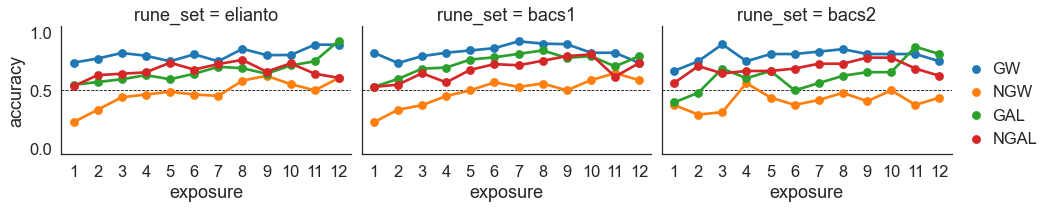

In [7]:
## Initialize canvas.
g = sns.FacetGrid(data, col='rune_set', col_order=['elianto','bacs1','bacs2'], aspect=1.5)
palette = sns.color_palette(n_colors=4)

## Plot performance.
g.map(sns.pointplot, 'exposure', 'accuracy', 'robot', order=np.arange(12)+1,
      hue_order=['GW','NGW','GAL','NGAL'], palette=palette, ci=None)

## Add details.
g.set(ylim=(-0.05,1.05))
g.add_legend(handletextpad=0)
for ax in g.axes.flatten(): ax.axhline(0.5, lw=0.8, linestyle='--', color='k', zorder=-1)

#### 4.2 Individual Differences

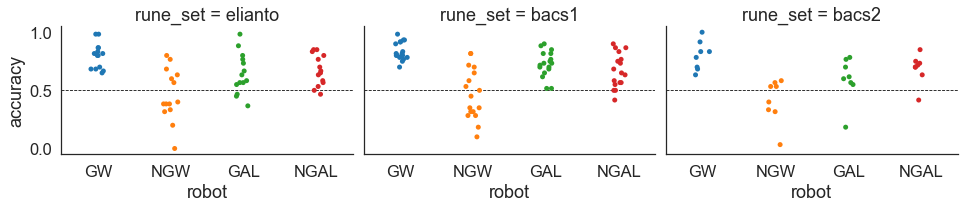

In [8]:
## Compute average within subjects.
gb = data.groupby(['subject','rune_set','robot']).accuracy.mean().reset_index()

## Initialize canvas.
g = sns.FacetGrid(gb, col='rune_set', col_order=['elianto','bacs1','bacs2'], aspect=1.5)
palette = sns.color_palette(n_colors=4)

## Plot performance.
g.map(sns.stripplot, 'robot', 'accuracy', order=['GW','NGW','GAL','NGAL'], palette=palette)

## Add detail.
g.set(ylim=(-0.05,1.05))
for ax in g.axes.flatten(): ax.axhline(0.5, lw=0.8, linestyle='--', color='k', zorder=-1)

## Section 5: Learning Effects

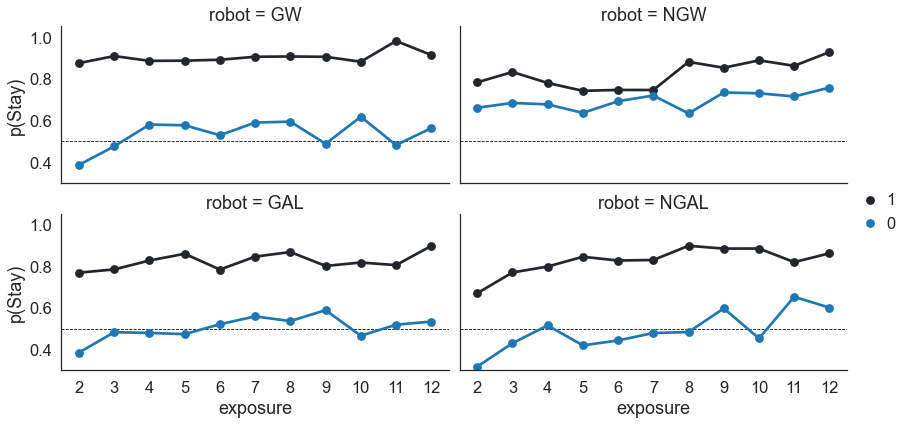

In [9]:
## Re-format data.
data = data.sort_values(['subject','block','rune','exposure']).reset_index(drop=True)

## Define previous choice / outcome.
data['prev_choice']  = np.roll(data.choice, 1)
data['prev_outcome'] = np.roll(data.outcome, 1)

## Define stay.
data['p(Stay)'] = np.where(data['choice']==data['prev_choice'], 1, 0)

## Mask first exposure.
data.loc[data.exposure==1, ['prev_choice','prev_outcome','p(Stay)']] = np.nan

## Initialize canvas.
g = sns.FacetGrid(data, col='robot', col_order=['GW','NGW','GAL','NGAL'], col_wrap=2, aspect=2)

## Plot performance.
g.map(sns.pointplot, 'exposure', 'p(Stay)', 'prev_outcome', order=np.arange(2,13), 
      hue_order=[1,0], ci=None)

## Add details.
g.set(ylim=(0.3,1.05))
g.add_legend(handletextpad=0)
for ax in g.axes.flatten(): ax.axhline(0.5, lw=0.8, linestyle='--', color='k', zorder=-1)

## Section 6: Metadata

In [10]:
## Load data.
metadata = read_csv(os.path.join('data','v0.2','metadata.csv'))

## Apply rejections.
metadata = metadata[metadata.subject.isin(data.subject)]

#### 5.1 Practice Trials

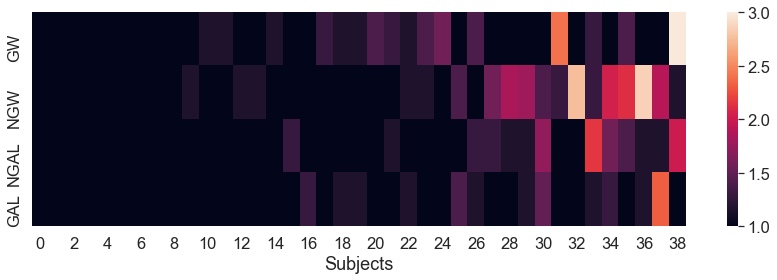

In [11]:
from math import log

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Extract practice trials.
counts = metadata.filter(regex='practice').T.values

## Convert to log_4.
log4 = np.vectorize(lambda x: log(x, 4))
counts = log4(counts)

## Re-sort by average number.
counts = counts[:,np.argsort(counts.mean(axis=0))]

## Plot number of practice trials.
sns.heatmap(counts, vmin=1, vmax=3, yticklabels=['GW','NGW','NGAL','GAL'])
ax.set(xlabel='Subjects')

plt.tight_layout()

#### 5.2 Self-Report Ratings

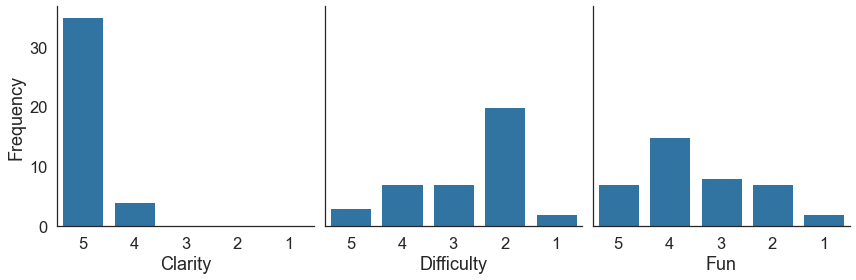

In [12]:
## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)

## Iterate over categories.
for i, (ax, var) in enumerate(zip(axes, ['clarity','difficulty','fun'])):
    
    ## Plot ratings.
    sns.countplot(x=var, data=metadata, order=[5,4,3,2,1], color='#1f77b4', ax=ax)
    
    ## Add detail.
    ax.set(xlabel=var.capitalize(), ylabel='Frequency' if not i else '')
    
sns.despine()
plt.tight_layout()